UID: **118782928 118895499 120380389 118979748**
(USING 2 LATEDAY PASSES)

# **CMSC426 Project 3: From Pixels to 3D Worlds : Two-View 3D Reconstruction**

# **Introduction**

We've spent a lot of time working with images, mostly in 2D scenes. Remember Project 1, where we stitched images together by finding common features between them? Well, now it’s time to take things up a notch! Imagine being able to create a 3D view of a scene using just two images and figuring out exactly where the camera was positioned relative to that scene. Sounds exciting, right?

This approach is actually a simplified version of something called Structure from Motion (SfM). While SfM usually involves reconstructing 3D structures from many images taken from different angles, we’ll start with something more manageable: Two-View Reconstruction. Instead of dealing with a whole collection of viewpoints, we’ll be focusing on building a 3D structure using only two images taken from different perspectives. The key idea? Matching features between these two images to reconstruct the scene in 3D and understand how the camera moved between shots.

* Feature Matching
* Outlier Rejection using RANSAC & Estimating the Fundamental Matrix
*  Estimating the Essential Matrix from the Fundamental Matrix
*  Estimating Camera Pose from the Essential Matrix
* Checking for Cheirality Condition using Triangulation
* Linear Triangulation of Points

Reading Module : https://cmsc733.github.io/2022/proj/p3/

Video Lecture : [link](https://drive.google.com/file/d/1KxBYehdtbVpH4A0vsNwbLpuLsGNqYH8F/view?usp=sharing)

Allowed functions: Any functions regarding reading, writing and displaying/plotting images in cv2, matplotlib

Basic math utitlies including convolution operations in numpy and math



# **Step 1: Feature Matching** [5 points]

In [ ]:
# Download data from Google Drive
import gdown
gdown.download_folder(id="1ROQl0NTBnxMjLrO5qISyxcTCJUPSMsRS", quiet=True, use_cookies=False)

['/content/project3/feature_points.npz',
 '/content/project3/image1.jpg',
 '/content/project3/image2.jpg',
 '/content/project3/intrinsics.npz',
 '/content/project3/monument_reconstruction.gif']

In [ ]:
def display_matches(img1, img2, pts1, pts2):
  """
  Visualize the matching points between two images.

  Input:
      img1: Image 1 in numpy array format.
      img2: Image 2 in numpy array format.
      pts1: Matched points in Image 1 (numpy array of shape Nx2).
      pts2: Matched points in Image 2 (numpy array of shape Nx2).
  """
  # Combine images horizontally
  img1_height, img1_width = img1.shape[:2]
  img2_height, img2_width = img2.shape[:2]
  combined_img = np.zeros((max(img1_height, img2_height), img1_width + img2_width, 3), dtype=np.uint8)
  combined_img[:img1_height, :img1_width] = img1
  combined_img[:img2_height, img1_width:] = img2

  # Red color in BGR format
  color = (0, 0, 255)

  # Draw lines between matched points
  for pt1, pt2 in zip(pts1, pts2):
    pt1 = (int(pt1[0]), int(pt1[1]))
    pt2 = (int(pt2[0]) + img1_width, int(pt2[1]))
    cv2.line(combined_img, pt1, pt2, color, 1)

  # Display the image
  plt.figure(figsize=(15, 10))
  plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

In [ ]:
def load_data(image1_path, image2_path,npz_path):
  # Load images
  img1 = cv2.imread(image1_path)
  img2 = cv2.imread(image2_path)

  # Load correspondences
  data = np.load(npz_path)
  pts1 = data['pts1']  # Nx2 array of points in the first image
  pts2 = data['pts2']  # Nx2 array of points in the second image
  return img1, img2,pts1, pts2

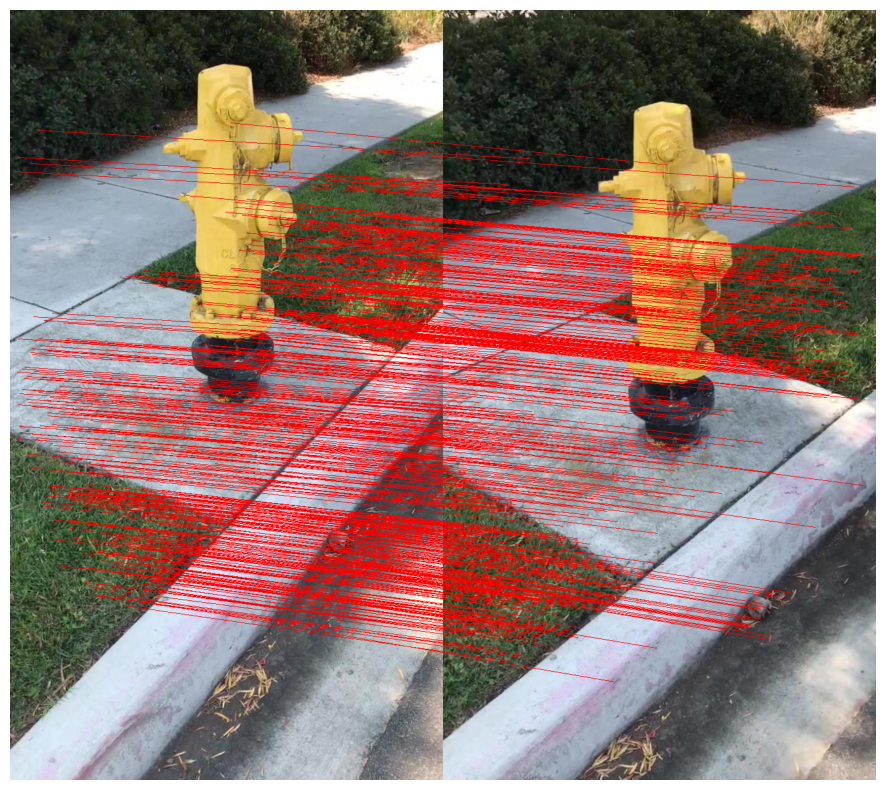

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# File paths
image1_path = '/content/project3/image1.jpg'
image2_path = '/content/project3/image2.jpg'
npz_path = '/content/project3/feature_points.npz'
intrinsics = np.load('/content/project3/intrinsics.npz')
K1 = intrinsics['K1']
K2 = intrinsics['K2']

# Load and display matches
img1, img2, pts1, pts2 = load_data(image1_path, image2_path, npz_path)
display_matches(img1, img2, pts1, pts2)

# **Step 2: Fundamental Matrix Estimation and RANSAC** [15 points]
<img src="https://cmsc733.github.io/assets/2019/p3/ransac.png">

In [ ]:
def normalize_points(points):
  # Compute the centroid of the points
  centroid = np.mean(points, axis=0)

  # Shift points to the origin
  shifted_points = points - centroid

  # Compute the average distance to the origin
  mean_distance = np.mean(np.sqrt(np.sum(shifted_points**2, axis=1)))

  # Scale factor to make the average distance sqrt(2)
  scale = np.sqrt(2) / mean_distance

  # Create the transformation matrix
  T = np.array([
    [scale, 0, -scale * centroid[0]],
    [0, scale, -scale * centroid[1]],
    [0, 0, 1]
  ])

  # Apply the transformation
  ones = np.ones((points.shape[0], 1))
  points_h = np.hstack((points, ones))
  normalized_points_h = (T @ points_h.T).T

  # Return normalized points (back to 2D) and the transformation matrix
  normalized_points = normalized_points_h[:, :2]
  return normalized_points, T

In [ ]:
def estimate_Fmatrix(img1_pts, img2_pts):
  """
  Estimate the Fundamental Matrix using matched points from two images.

  Input:
      img1_pts: Matched points from Image 1 (numpy array of shape Nx2).
      img2_pts: Matched points from Image 2 (numpy array of shape Nx2).

  Output:
      F: Estimated Fundamental Matrix (3x3 numpy array).
  """
  # use given pairs of points
  A = []
  for (x1, y1), (x2, y2) in zip(img1_pts, img2_pts):
    A.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
  A = np.array(A)
  # solve A^T A F=0
  U, S, Vt = np.linalg.svd(A.T @ A,full_matrices=True)
  x=Vt[8]
  F = np.array([[x[0],x[3],x[6]], [x[1],x[4],x[7]],[x[2],x[5],x[8]]])
  F = F/F[2][2]
  #checking if F is correct
  #for (x1, y1), (x2, y2) in zip(img1_pts, img2_pts):
  #  eps = x1*x2*F[0][0]+x1*y2*F[1][0]+x1*F[2][0]+y1*x2*F[0][1]+y1*y2*F[1][1]+y1*F[2][1]+x2*F[0][2]+y2*F[1][2]+F[2][2]
  #  print("eps should be zero:",eps)
  return F

In [ ]:
def ransac(pts1, pts2, iterations=1000, threshold=0.005):
  """
  Apply RANSAC to estimate the Fundamental Matrix robustly.

  Input:
      pts1: Points from Image 1 (numpy array of shape Nx2).
      pts2: Points from Image 2 (numpy array of shape Nx2).
      iterations: Number of RANSAC iterations (int).
      threshold: Distance threshold for inliers (float).

  Output:
      img1_inliers: Inliers from Image 1 (numpy array of shape Mx2).
      img2_inliers: Inliers from Image 2 (numpy array of shape Mx2).
      best_F: Best Fundamental Matrix found (3x3 numpy array).
  """
  n = 0
  S_best = []
  F_best = None

  for i in range(iterations):
    #gets 8 random points and passes them to estimate f
    rand_8 = random.sample(range(len(pts1)), 8)
    img1_pts =  np.array([pts1[i] for i in rand_8])
    img2_pts = np.array([pts2[i] for i in rand_8])
    # Estimate Fundamental Matrix from 8 points
    S = []
    F = estimate_Fmatrix(img1_pts, img2_pts)

    if F is None or F.size == 0:
      continue

    for j in range(len(pts1)):
      # Convert points to homogeneous coordinates
      v1 = np.array([pts1[j][0], pts1[j][1], 1])
      v2 = np.array([pts2[j][0], pts2[j][1], 1])

      # Compute epipolar constraint error
      eps = np.abs(np.dot(v2.T, np.dot(F, v1)))

      # Count as inlier if error is below the threshold
      if eps < threshold:
        S.append(j)

    # Update best set of inliers if current set is better
    if len(S) > n:
      n = len(S)
      S_best = S
      F_best = F

  # Extract inliers from the best set
  img1_inliers = pts1[S_best]
  img2_inliers = pts2[S_best]

  return img1_inliers, img2_inliers, F_best

In [ ]:
img1_inliers, img2_inliers, F = ransac(pts1, pts2)
print(F)
print(len(img1_inliers))

[[ 3.42697350e-07  1.69978164e-06 -3.71872973e-03]
 [-7.33940004e-07  8.97906731e-07 -8.36874163e-03]
 [ 3.53325044e-03  6.86564097e-03  1.00000000e+00]]
413


# **Draw epipolar lines** [10 points]

In [ ]:
def compute_epipolar_lines_manual(pts, F):
  """
  Compute epipolar lines for given points using the Fundamental Matrix.

  Input:
      pts: Points in homogeneous coordinates (numpy array of shape Nx2).
      F: Fundamental Matrix (3x3 numpy array).

  Output:
      lines: Epipolar lines in homogeneous form (Nx3 numpy array).

  Comments:
      - Converts points to homogeneous coordinates.
      - Computes lines using the Fundamental Matrix.
  """
  # Convert points to homogeneous coordinates
  ones = np.ones((pts.shape[0], 1))
  pts_h = np.hstack((pts, ones))  # Nx3 matrix

  # Compute epipolar lines (vectorized operation)
  lines = np.dot(F, pts_h.T).T  # Result is Nx3 matrix

  # Normalize lines
  norm_factors = np.sqrt(lines[:, 0]**2 + lines[:, 1]**2)
  lines /= norm_factors[:, np.newaxis]

  return lines

def draw_epipolar_lines_img1_points_img2_lines(img1, img2, pts1, F):
  """
  Draw epipolar lines on the second image for points from the first image.

  Input:
      img1: Image 1 in numpy array format.
      img2: Image 2 in numpy array format.
      pts1: Points in Image 1 (numpy array of shape Nx2).
      F: Fundamental Matrix (3x3 numpy array).
  """
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Compute epipolar lines
  lines = compute_epipolar_lines_manual(pts1, F)

  image_epipolar_lines = img2.copy()

  for line in lines:
    A, B, C = line

    # Calculate endpoints
    x0, x1 = 0, img2.shape[1] - 1
    y0 = int(-1 * (A * x0 + C) / B)
    y1 = int(-1 * (A * x1 + C) / B)

    color = tuple(np.random.randint(0, 255, 3).tolist())

    # Draw the epipolar line on the second image
    cv2.line(image_epipolar_lines, (x0, y0), (x1, y1), color, 2)

  image_inlier_points = img1.copy()

  # Draw each point
  for (x, y) in pts1:
    cv2.circle(image_inlier_points, (int(x), int(y)), color=(50, 205, 50), radius=5, thickness=-1)

  # Display the first image
  axes[0].set_title("Viewpoint 1 (Points Only)")
  axes[0].imshow(cv2.cvtColor(image_inlier_points, cv2.COLOR_BGR2RGB))
  axes[0].axis("off")

  # Display the second image
  axes[1].set_title("Viewpoint 2 (Epipolar Lines Only)")
  axes[1].imshow(cv2.cvtColor(image_epipolar_lines, cv2.COLOR_BGR2RGB))
  axes[1].axis("off")

  # Adjust layout
  fig.tight_layout()

  # Show the figure
  plt.show()

  return

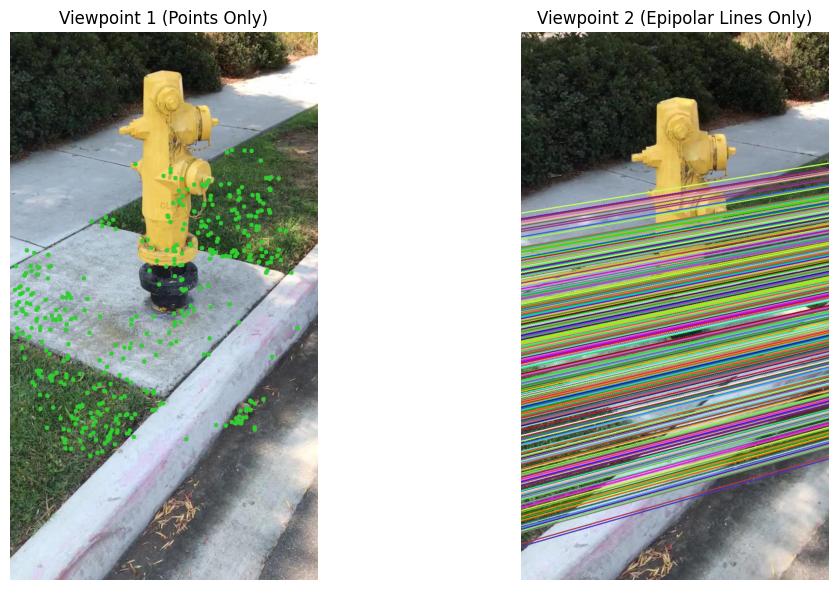

In [ ]:
# Draw epipolar lines based on the fundamental matrix
draw_epipolar_lines_img1_points_img2_lines(img1, img2, img1_inliers, F)

# **Step 3: Estimate Essential Matrix E** [15 points]



In [ ]:
def estimate_Essentialmatrix(K1, K2, F):
  """
  Estimate the Essential Matrix using camera intrinsics and the Fundamental Matrix.

  Input:
      K1: Intrinsic matrix of Camera 1 (3x3 numpy array).
      K2: Intrinsic matrix of Camera 2 (3x3 numpy array).
      F: Fundamental Matrix (3x3 numpy array).

  Output:
      E: Estimated Essential Matrix (3x3 numpy array).
  """

  E = K2.T @ F @ K1
  return E

In [ ]:
E = estimate_Essentialmatrix(K1, K2, F)
print("Essential Matrix E:\n",E )

Essential Matrix E:
 [[  0.22264277  -3.38514705  -3.6404433 ]
 [  5.37588374   0.60289917 -16.47117758]
 [  4.49550568  16.81159296   0.99948835]]


# **Step 4: Extracting Poses form E matrix** [20 points]
<img src = "https://drive.google.com/uc?export=view&id=1vizqzdm0gB4sRWQSrvZZPjwezW2OG5tE">




In [ ]:
def enforce_valid_rotation(R, T):
  if np.linalg.det(R) < 0:
    R = -R
    T = -T
  return R, T

In [ ]:
def get_RTset(E):
  """
  Extract possible sets of rotation (R) and translation (T) from the Essential Matrix.

  Input:
      E: Essential Matrix (3x3 numpy array).

  Output:
      R: List of possible rotation matrices (4x 3x3 numpy arrays).
      T: List of possible translation vectors (4x 3x1 numpy arrays).

  Comments:
      - Uses SVD decomposition of the Essential Matrix.
      - Constructs four possible (R, T) pairs and ensures valid rotations
  """
  U, S, V_transpose = np.linalg.svd(E)
  V = V_transpose.T

  W = np.array([
    [0, -1, 0],
    [1,  0, 0],
    [0,  0, 1],
  ])

  # Case 1: (R1, T1)
  R1 = U @ W @ V_transpose
  T1 = U[:, 2]

  # Case 2: (R2, T2)
  R2 = U @ W @ V_transpose
  T2 = -U[:, 2]

  # Case 3: (R3, T3)
  R3 = U @ W.T @ V_transpose
  T3 = U[:, 2]

  # Case 4: (R4, T4)
  R4 = U @ W.T @ V_transpose
  T4 = -U[:, 2]

  R1, T1 = enforce_valid_rotation(R1, T1)
  R2, T2 = enforce_valid_rotation(R2, T2)
  R3, T3 = enforce_valid_rotation(R3, T3)
  R4, T4 = enforce_valid_rotation(R4, T4)

  # Return all possible configurations
  R = [R1, R2, R3, R4]
  T = [T1.reshape(3, 1), T2.reshape(3, 1), T3.reshape(3, 1), T4.reshape(3, 1)]

  return R, T

In [ ]:
setr,setc = get_RTset(E)
print(setr)
print(setc)

[array([[ 0.99271422, -0.05744565,  0.10591729],
       [ 0.05296563,  0.99759816,  0.044638  ],
       [-0.10822716, -0.0387028 ,  0.99337253]]), array([[ 0.99271422, -0.05744565,  0.10591729],
       [ 0.05296563,  0.99759816,  0.044638  ],
       [-0.10822716, -0.0387028 ,  0.99337253]]), array([[ 0.77184004, -0.44676598,  0.45239706],
       [-0.42185342, -0.89219051, -0.16135606],
       [ 0.47571277, -0.06630418, -0.87709812]]), array([[ 0.77184004, -0.44676598,  0.45239706],
       [-0.42185342, -0.89219051, -0.16135606],
       [ 0.47571277, -0.06630418, -0.87709812]])]
[array([[-0.95911366],
       [ 0.20050691],
       [-0.19974476]]), array([[ 0.95911366],
       [-0.20050691],
       [ 0.19974476]]), array([[-0.95911366],
       [ 0.20050691],
       [-0.19974476]]), array([[ 0.95911366],
       [-0.20050691],
       [ 0.19974476]])]


# **Step 5: Linear Triangulation** [15 points]


In [ ]:
def triangulate_points(P1, P2, pts1, pts2):
  num_points = pts1.shape[0]
  points_3d = []

  for i in range(num_points):
    x1, y1 = pts1[i]
    x2, y2 = pts2[i]

    # Build the linear system for triangulation
    A = np.zeros((4, 4))
    A[0] = y1 * P1[2] - P1[1]
    A[1] = x1 * P1[2] - P1[0]
    A[2] = y2 * P2[2] - P2[1]
    A[3] = x2 * P2[2] - P2[0]

    # Solve for the 3D point using SVD
    _, _, V_transpose = np.linalg.svd(A)
    X = V_transpose[-1]
    X = X / X[-1]
    points_3d.append(X[:3])

  return np.array(points_3d)

In [ ]:
def linear_triangulation(R_Set, T_Set, pt1, pt2, K):
  """
  Perform linear triangulation to estimate 3D points.

  Input:
      R_Set: List of possible rotation matrices (4x 3x3 numpy arrays).
      T_Set: List of possible translation vectors (4x 3x1 numpy arrays).
      pt1: Points in Image 1 (numpy array of shape Nx2).
      pt2: Points in Image 2 (numpy array of shape Nx2).
      k: Camera intrinsic matrix (3x3 numpy array).

  Output:
      points_3d_set: List of 3D points for each (R, T) pair.

  Comments:
      - Triangulates 3D points for each (R, T) pair.
  """
  # Initialize storage for 3D points for each (R, T) pair
  points_3d_set = []

  # Loop over each (R, T) pair
  for i in range(4):
    R = R_Set[i]
    T = T_Set[i]

    # Construct the projection matrices
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, T))

    # Perform triangulation
    points_3d = triangulate_points(P1, P2, pt1, pt2)
    points_3d_set.append(points_3d)

  return points_3d_set

# **Step 6: Cheriality condition** [20 points]

In [ ]:
def extract_pose(R_set, T_set, pts_3d_set):
  """
  Select the best pose (R, T) that satisfies the chirality condition.

  Input:
      R_set: List of possible rotation matrices (4x 3x3 numpy arrays).
      T_set: List of possible translation vectors (4x 3x1 numpy arrays).
      pts_3d_set: List of 3D point sets for each (R, T) pair.

  Output:
      R_best: Best rotation matrix (3x3 numpy array).
      T_best: Best translation vector (3x1 numpy array).
      X_best: Best 3D points (Nx3 numpy array).
      index: Index of the best (R, T) pair.
  """
  best_count = 0
  best_index = -1
  R_best = None
  T_best = None
  X_best = None

  # Loop through each possible (R, T) pair
  for i in range(4):
    R = R_set[i]
    T = T_set[i]
    pts_3d = pts_3d_set[i]

    # Get the third row of the rotation matrix (r3)
    r3 = R[2, :]  # The third row (z-axis) of the rotation matrix

    # Check how many points satisfy the chirality condition
    count_valid_points = compute_cheriality(pts_3d, r3, T)

    # Update the best configuration if this one has more valid points
    if count_valid_points > best_count:
      best_count = count_valid_points
      best_index = i
      R_best = R
      T_best = T
      X_best = pts_3d

  return R_best, T_best, X_best, best_index

In [ ]:
def compute_cheriality(pt, r3, t):
  """
  Compute the chirality condition to determine if points are in front of the camera.

  Input:
      pt: 3D points (Nx3 numpy array).
      r3: Third row of the rotation matrix (1x3 numpy array).
      t: Translation vector (3x1 numpy array).

  Output:
      count_depth: Number of points with positive depth.
  """
  # Compute the camera center
  C = -np.dot(r3.T, t)

  # Calculate depth for each 3D point
  # Subtract the camera center from each 3D point
  pts_relative = pt - C
  depths = np.dot(pts_relative, r3.T)

  # Count how many points are in front of the camera (depth > 0)
  count_depth = np.sum(depths > 0)

  return count_depth

In [ ]:
R_set, T_set = get_RTset(E)

In [ ]:
point3D_set = linear_triangulation(R_set, T_set, img1_inliers, img2_inliers, K1)

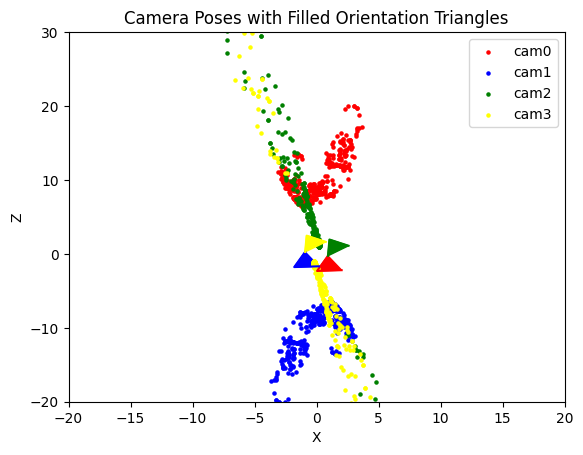

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

colors = ['red', 'blue', 'green', 'yellow']
fig, ax = plt.subplots()

def plot_camera_pose(ax, position, orientation, color):
  scale = 2
  triangle = np.array([
    [0, 0],
    [-0.5, -1],
    [0.5, -1]
  ]) * scale

  # Rotate and translate triangle
  rotation = orientation[:2, :2]
  transformed_triangle = (rotation @ triangle.T).T + position[:2]

  # Create filled polygon
  polygon = Polygon(transformed_triangle, closed=True, color=color)
  ax.add_patch(polygon)

  # Ensure proper aspect ratio
  ax.plot(transformed_triangle[:, 0], transformed_triangle[:, 1], color=color)

for i in range(len(R_set)):
  points = point3D_set[i]
  ax.scatter(points[:, 0], points[:, 2], c=colors[i], label=f'cam{i}', s=5)

  # Camera position and orientation
  camera_origin = -R_set[i].T @ T_set[i].flatten()
  rotation_matrix = R_set[i]
  plot_camera_pose(ax, position=camera_origin, orientation=rotation_matrix, color=colors[i])

# Set axis limits
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 30)

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.legend()
ax.set_title("Camera Poses with Filled Orientation Triangles")

plt.show()

In [ ]:
# Get pose of camera using chirality condition
R_best, T_best, X_, index= extract_pose(R_set,T_set,point3D_set)

In [ ]:
def plot_3d_point_cloud(points_3d, img, K):
  """
  Plot a 3D point cloud with RGB colors extracted from an image, matching a specific orientation and axis ranges.

  Input:
      points_3d: Nx3 numpy array of 3D points.
      img: Image (numpy array of shape HxWx3) to get colors from.
      K: Camera intrinsic matrix (3x3 numpy array).
  """
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Project 3D points onto the image plane
  points_homogeneous = np.hstack((points_3d[:, :3], np.ones((points_3d.shape[0], 1))))
  projected_points = (K @ points_homogeneous[:, :3].T).T
  projected_points /= projected_points[:, 2].reshape(-1, 1)

  # Extract pixel coordinates
  pixel_coords = projected_points[:, :2].astype(int)  # Nx2 pixel coordinates (x, y)
  img_height, img_width = img.shape[:2]

  colors = []

  for coord in pixel_coords:
    x, y = coord
    colors.append(img_rgb[y, x])

  colors = np.array(colors) / 255.0

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=colors, s=10, marker='o', label="Colored 3D Points")
  ax.scatter([0], [0], [0], c='red', s=50, marker='^', label="Camera Pose")

  # Set axis labels
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  # Set axis ranges to match the reference plot
  ax.set_xlim(-7.5, 7.5)
  ax.set_ylim(-15, 2.5)
  ax.set_zlim(0, 20)

  # Adjust the viewing angle
  ax.view_init(elev=80, azim=90)

  # Add legend and title
  ax.legend()
  ax.set_title("Colored 3D Point Cloud and Camera Pose")

  plt.show()

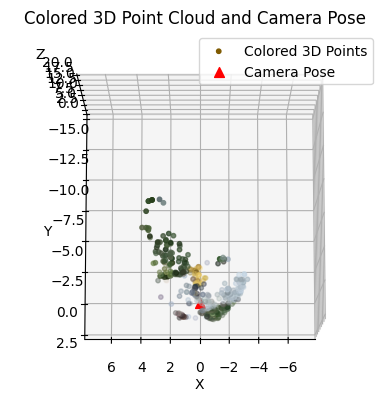

In [ ]:
# Test the function
plot_3d_point_cloud(X_, img1, K1)

# **Extra Credit: Reconstruct Your Own Scene! (30 Points)**

In [ ]:
# You can access the GIF via this link
!wget https://drive.google.com/file/d/1a4Ohpiv5fstIsr92P0A8zDc4EbymrO-s/view?usp=sharing -O scene.gif

from IPython.display import Image, clear_output
clear_output()
Image(open('scene.gif','rb').read())

## Report
You will be graded primarily based on your report.
A demonstration of understanding of the concepts involved in the project are required show the output produced by your code.

Include visualizations of the output of each stage in your pipeline (as shown in the system diagram on page 2), and a description of what you did for each step. Assume that we’re familiar with the project, so you don’t need to spend time repeating what’s already in the course notes. Instead, focus on any interesting problems you encountered and/or solutions you implemented.

For each stage there is visualization in the output such as in step 1, 3, and 7
1. **Step 1 (Feature Matching):** We began by matching corresponding feature points between the two images. These images represent the same 3D points projected onto different 2D planes. The matched points were then visualized by plotting them on both images to verify that they were correctly aligned, ensuring an accurate correspondence between the views. We did not have issues with this step and the points were given.

2. **Step 2 (Fundamental Matrix Estimation):** The next step involved estimating the fundamental matrix, which captures the epipolar geometry between the two views, constraining the possible locations of corresponding points in one image based on their location in the other. To do this, we randomly selected 8 points then computed a fundemental matrix for those points using SVD to solve the linear equation. We then normalize the matrix by dividing by the last row last column element to ensure that it is one. Following this, we used the Random Sample Consensus (RANSAC) algorithm to iteratively remove outliers, refining the fundamental matrix and providing a more robust and accurate estimate that better reflects the epipolar geometry between the two views. Some problems we had with this was ensuring the fundemental matrix was computed accurately which we checked by ensuring the equation equaled zero. We also checked by ensuring our fundemental matrix was giving similar results to the fundemental matrix cv2 made from the same points. We printed the F matrix after the RANSAC algorithm for this step for visualization.

3. **Step 3 (Compute Epipolar Lines):** To visualize the epipolar geometry and verify the accuracy of the fundamental matrix, we computed the epipolar lines corresponding to the matched points. For each point in one image, its corresponding point in the other image must lie on its respective epipolar line. This step not only validated the correctness of the fundamental matrix but also helped in confirming that the estimated correspondences were geometrically consistent with the epipolar geometry, guiding further matching and refinement if necessary. We calculated the lines using basic line calculations and used cv2.line to draw the lines in the second image. We used cv2.circle to plot the points in the first image.

4. **Step 4 (Essential Matrix Estimation):** Using the intrinsic camera matrices, which describe the internal camera parameters and were given to us (e.g., focal length, principal point), and the previously estimated fundamental matrix, we computed the essential matrix. The essential matrix encapsulates the relative pose (rotation and translation) between the two cameras, assuming that the camera calibration (intrinsics) is known. This step is crucial because it provides the necessary transformation between the two camera views to enable 3D reconstruction from 2D point correspondences. We followed the given forumals in order to create this matrix and did not run into any problems in this step. We also created a helper function to check and correct rotation. We printed the essential matrix for visualization in this step

5. **Step 5 (Camera Pose Extraction):** From the essential matrix, we extracted four potential configurations for the second camera's position and orientation relative to the first. These configurations were determined by applying singular value decomposition (SVD) to the essential matrix, which decomposes it into a rotation matrix and a translation vector. The four configurations represent different combinations of possible rotation and translation between the cameras. We evaluated each configuration based on the scene geometry to identify the correct relative camera pose. We did not encounter any issues with this step as well. We printed the rotation and translation matrices for visualization in this step.

6. **Step 6 (Linear Triangulation):** Using the potential camera poses derived from the essential matrix and the matched feature points, we performed linear triangulation to compute the 3D coordinates of the scene points. We used a helper function to make computation easier. The visualization for this step relates to the next step so that is where we have visualization.

7. **Step 7 (Chirality Condition):** To resolve the ambiguity in the camera poses and select the correct one, we applied the chirality condition. This condition checks that the reconstructed 3D points lie in front of both cameras, as any valid 3D point should be observable by both camera perspectives. In this step, we also plotted the camera poses and ran into some issues with getting the corect colors and matching the look of the expected graph. We also ran into some issues with the 3d graph with obtaining the proper colors and ensuring the axes were correct.

8. **Extra Credit:** We looked for sets of images of the same object or scene in our camera rolls, testing them by applying automatic reconstruction in the COLMAP software. This only produced a meaningful reconstruction once or twice, and often couldn't make one at all. The GIF is a scene produced from 9 images of two buildings on campus.  https://drive.google.com/file/d/1a4Ohpiv5fstIsr92P0A8zDc4EbymrO-s/view?usp=sharing

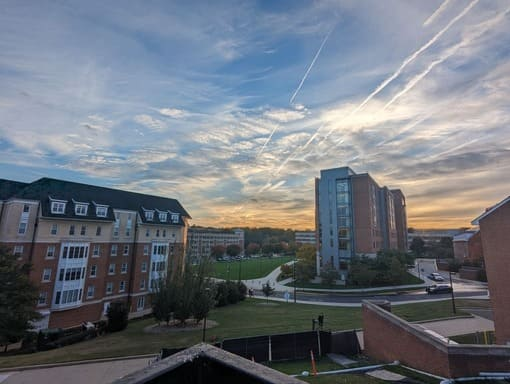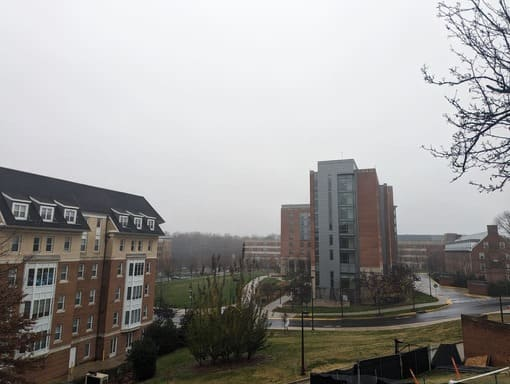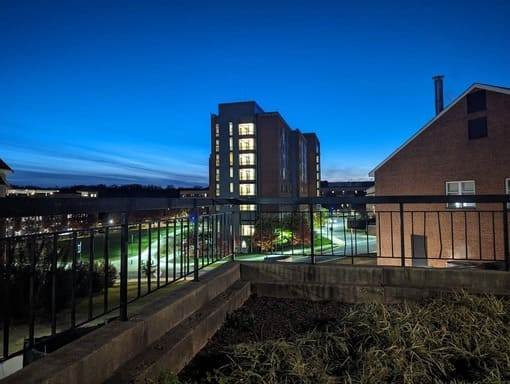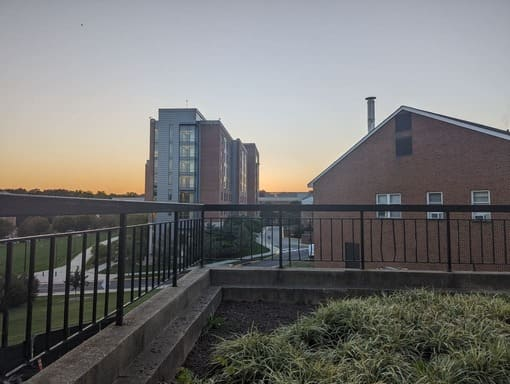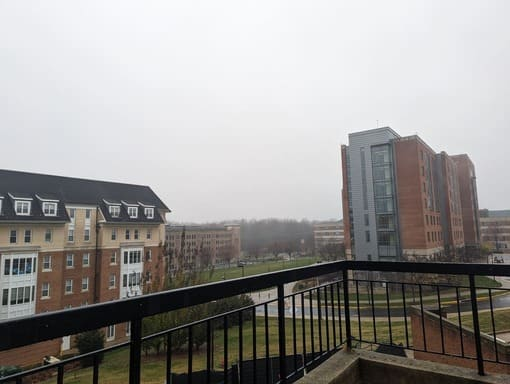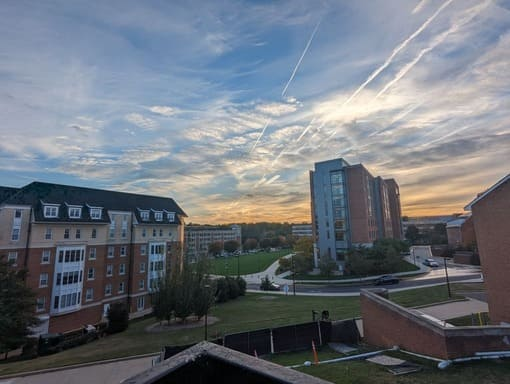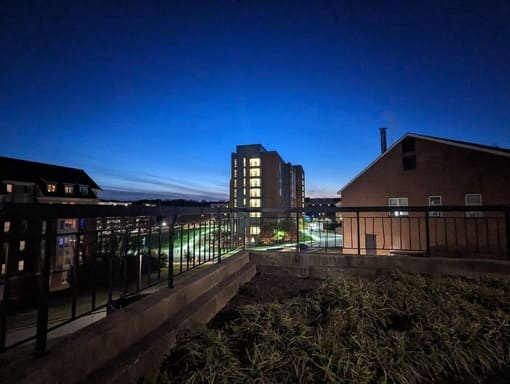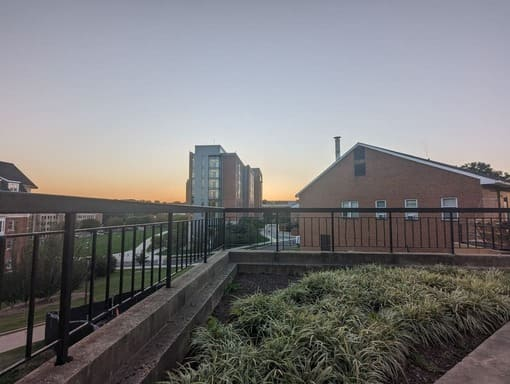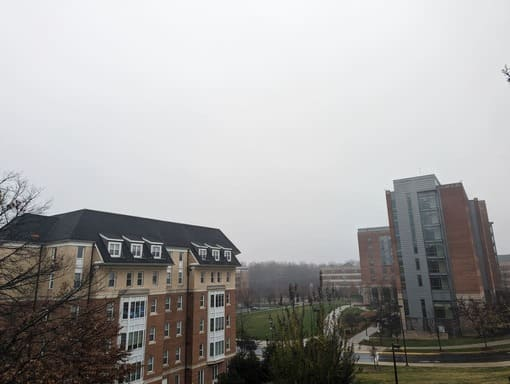

# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj3.pdf**. For example, xyz123_proj3.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.

Project Inspiration Credit to CMSC733 COmputer Vision and 16-822: Geometry-based Methods in Vision
